### Blackjack
1. 문제: policy가 주어진 상태에서 blackjack 게임을 할 때의 value function을 구해보자.
2. 조건
    - state: dealer의 1번째 카드, player의 카드의 총 합, ace 카드 사용 가능 여부(1 &harr; 11)
    - action: 카드를 더 받거나(hit) 그만 받는다(stick) 
        - 그만 받는 경우에 dealer의 턴이 되며 dealer는 총 합이 17보다 작은 경우 카드를 계속 받고(hit) 17보다 같거나 큰 경우 그만 받는다.(stick)
    - reward: 승리(+1), 무승부(0), 패배(-1)
    - terminal:
        - 승리: dealer 턴에 21을 넘는 경우, 혹은 player 턴에 stick 했을 때 카드 합산이 dealer보다 높은 경우 
        - 무승부: 시작 카드의 합이 player, dealer 모두 21(natural)일 경우
        - 패배: player 턴에 21을 넘는 경우, 혹은 player 턴에 stick 했을 때 카드 합산이 dealer보다 낮은 경우 
    - policy: 
        - hit: player 카드 합이 20보다 작은 경우 
        - stick: player 카드 합이 20 혹은 21인 경우 
3. 학습 목표
    - First-visit MC prediction

In [1]:
from collections import defaultdict
import random

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
matplotlib.style.use('ggplot')

#### Deck
- 덱은 52개 카드로 이루어지며 카드를 모두 사용한 경우 새로운 덱을 shuffling 해서 사용한다. 

In [2]:
HIT = 1
STICK = 0
WIN = 1
LOSE = -1
DRAW = 0

# replacement = False
class Deck:
    def __init__(self, random=True):
        self.cards = [i for i in range(1, 10)]*4 + [10, 10, 10]*4
        self.random = random
        self.gen()
        
    def gen(self):
        if self.random:
            random.shuffle(self.cards)
        self.deck = (i for i in self.cards)
        
    def draw_card(self):
        try:
            return next(self.deck)
        except StopIteration:
            self.gen()
            return next(self.deck)

def draw_card(deck):
    return next(deck)
    
def is_bust(hand):
    return hand_sum(hand) > 21

def cmp(a, b):
    return int(a > b) - int(a < b) 

def usable_ace(hand):
    return 1 in hand and sum(hand) <= 11

def hand_sum(hand):
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)

def draw_cards(deck):
    return [next(deck), next(deck)]

#### Blackjack
- player의 초기 상태는 카드의 합이 12 이상이 될 때까지 카드를 뽑는다. 
- ace는 가지고 있을 때 21을 넘지 않는 이상 11의 역할을 하게 된다. 21을 넘은 경우 1의 역할을 한다. 

In [3]:
class Blackjack:    
    def __init__(self, deck):
        self.deck = deck
        self.reset()
            
    def reset(self):
        self.player_cards = [self.deck.draw_card(), self.deck.draw_card()]
        self.dealer_cards = [self.deck.draw_card(), self.deck.draw_card()]
                                    
        while hand_sum(self.player_cards) < 12:                 
            self.player_cards.append(self.deck.draw_card())                    
        return self._get_obs()
    
    def _get_obs(self):
        return (self.dealer_cards[0], hand_sum(self.player_cards), usable_ace(self.player_cards))
    
    def step(self, action):    
        done = False
        reward = 0
        if action == HIT:
            self.player_cards.append(self.deck.draw_card())            
            if is_bust(self.player_cards):
                reward = -1
                done = True            
        else:
            while hand_sum(self.dealer_cards) < 17:
                self.dealer_cards.append(self.deck.draw_card())
                if is_bust(self.dealer_cards):                    
                    reward = 1   
                    done = True                        
            if not done:
                reward = cmp(hand_sum(self.player_cards), hand_sum(self.dealer_cards))
                done = True
        return ([self._get_obs(), reward, done])

#### policy
고정된 policy가 주어진다. player는 카드 총 합이 20 이상의 경우 stick을 20미만의 경우 hit을 한다. 

In [6]:
def fixed_policy(state):
    dealer_card, player_sum, usable_ace_player = state
    if player_sum < 20:
        return HIT
    else:
        return STICK

#### First-visit MC prediction
return을 구할 때 episode내 state 중복 방문을 제외한다. blackjack 문제에서는 중복된 state를 방문 할 경우가 없으므로 first-visit와 every-visit MC의 결과가 동일하다.

![first visit mc](../images/first_visit_mc.png)
<center> 출처: Reinforcement Learning : An Introduction. Richard S. Sutton and Andrew G. Barto. 2017 (pp. 76) </center>

In [9]:
def first_visit_mc_prediction(env, policy_fn, num_episodes, discount_factor=1.0):
    # dealer's showing card: 1 - 10, players sum: 12 - 12 
    return_sum = defaultdict(float)
    return_count = defaultdict(float)
    
    V = defaultdict(float)
    
    for i_episode in range(num_episodes):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
        state = env.reset()    
        episode = []
        while True:
            action = policy_fn(state)
            next_state, reward, done = env.step(action)
            episode.append((state, action, reward))
            state = next_state
            if done:
                break
                
        states_in_episodes = set(x[0] for x in episode)
        for state in states_in_episodes:
            first_occurrence_idx = next(i for i, x in enumerate(episode) if state == x[0])
            G = sum(x[2]*(discount_factor**i) for i, x in enumerate(episode[first_occurrence_idx:]))
            return_sum[state] += G
            return_count[state] += 1.0
            V[state] = return_sum[state] / return_count[state]        
    return V

In [10]:
deck = Deck()
env = Blackjack(deck)
V = first_visit_mc_prediction(env, fixed_policy, 500000)

Episode 499000/500000.

In [11]:
def plotting(data, usable_ace=True):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    axisX = []
    axisY = []
    axisZ = []
    for i in range(1, 11):
        for j in range(12, 22):
            axisX.append(i)
            axisY.append(j)
            axisZ.append(data[(i, j, usable_ace)])
    ax.scatter(axisX, axisY, axisZ)
    ax.set_xlabel('dealer showing')
    ax.set_ylabel('player sum')
    ax.set_zlabel('value')
    ax.set_xlim(0, 10)
    ax.set_ylim(12, 21)
    ax.set_zlim(-1, 1)
    plt.show()

#### Figure 5.1
- ace가 있는 경우(`usable_ace = True`)의 player의 카드 합에 대한 value function의 값
- ace가 없는 경우(`usable_ace = False`)의 player의 카드 합에 대한 value function의 값

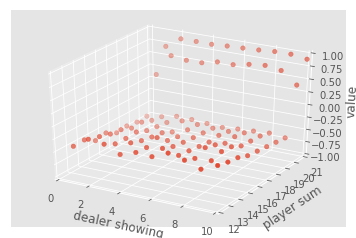

In [14]:
plotting(V, True)

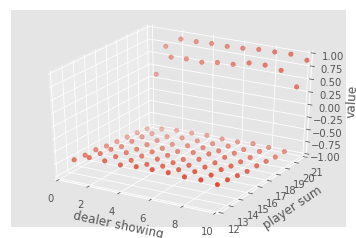

In [15]:
plotting(V, False)